In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import matplotlib as mpl
import sys


from nbodykit.lab import *

from colossus.cosmology import cosmology
cosmo_c = cosmology.setCosmology('planck15')

In [2]:
def measure_autopk(array,L):
    mesh = ArrayMesh(array,BoxSize=L)
    r = FFTPower(mesh, mode='1d')
    return r.power

In [154]:
def noise(nc):
    # Build a unit-distribution of complex numbers with random phase
    a = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    b = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    return a + 1j * b

In [155]:
L=200
nc=256
wn = noise(nc)
a = measure_autopk(wn,L)

[]

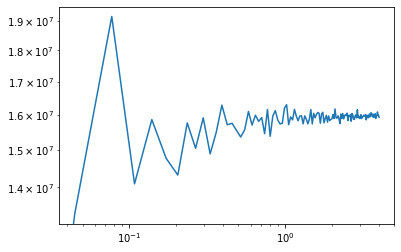

In [156]:
plt.plot(a['k'].real,a['power'].real)
plt.loglog()

In [135]:
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
p*=cosmo_c.growthFactor(100)*cosmo_c.growthFactor(100)

In [136]:
"""Create k^2 in box (nc x nc x nc)"""
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return (np.sqrt(k2))

In [137]:
kbox = k_box(nc,L)

In [138]:
z = int(nc/2)
kbox[0,0,1]

0.031415926535897934

In [139]:
Pk_box = np.interp(kbox,k,p)

In [149]:
wnpk = wn *np.sqrt(Pk_box/2/nc**6/L**3)
               
a1 = np.fft.ifftn(wnpk)
a2 = np.fft.fftn(wnpk)

In [150]:
b1 = measure_autopk(a1.real,L)
b2 = measure_autopk(a2.real,L)

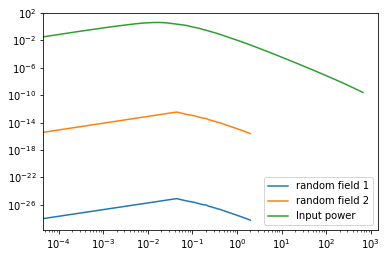

In [151]:
plt.plot(b1['k'].real,b1['power'].real,label="random field 1")
plt.plot(b2['k'].real,b2['power'].real,label="random field 2")

plt.plot(k,p,label="Input power")
plt.loglog()
#plt.xlim(0.01,10)
#plt.ylim(1E-3,1E1)
plt.legend()

In [89]:
def plot_slice(a1):
    cmap = plt.get_cmap('jet')
    start = 64
    num=1
    end = 64+num
    c= a1[:,start:end,:].mean(axis=1)
    c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

    im = plt.imshow((c+1).T,interpolation='bilinear',origin='lower',aspect='auto',cmap=cmap)
    ax.set_aspect('equal')

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="2%")
    cb = plt.colorbar(im,orientation='vertical',cax=cax)
    cb.ax.get_yaxis().labelpad = 0.
    plt.show()

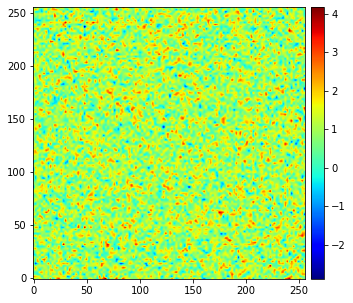

In [111]:
plot_slice(wn.real)

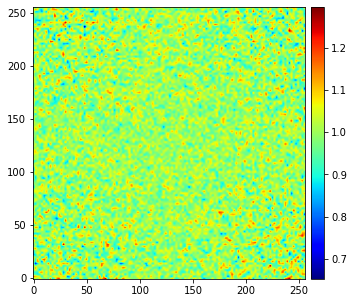

In [112]:
plot_slice(wnpk.real)

In [183]:
a = np.linspace(0,63,64).reshape((4,4,4))

In [79]:
np.fft.fftn(np.fft.fftn(a)).real/64

TypeError: unsupported operand type(s) for /: 'BinnedStatistic' and 'int'

In [83]:
a.shape



(128,)

In [84]:
boxvol = np.product(map(float,a.shape))


In [85]:
boxvol

In [87]:
pixelsize = boxvol/(np.product((a.shape)))

TypeError: unsupported operand type(s) for /: 'map' and 'int'

In [88]:
pixelsize = boxvol/(np.product(a.shape))

TypeError: unsupported operand type(s) for /: 'map' and 'int'

In [89]:
np.product(a.shape)

128

In [106]:
def _get_dims(box_dims, ashape):
    '''
    If box dims is a scalar, assume that dimensions
    are cubic and make a list
    If it's not given, assume it's the default value of the box
    size
    Otherwise, return as it is
    '''
    if box_dims == None:
        return [conv.LB]*len(ashape)
    if not hasattr(box_dims, '__iter__'):
        return [box_dims]*len(ashape)
    return box_dims

In [147]:
box_dims = _get_dims(L, wn.shape)

In [148]:
box_dims

[100, 100, 100]

In [151]:
boxvol = np.product(map(float,box_dims))
list(boxvol)

[100.0, 100.0, 100.0]

In [150]:
boxvol = np.product(map(float,box_dims))
pixelsize = boxvol/(np.product(wn.shape))
scale_factor = pixelsize**2/boxvol

TypeError: unsupported operand type(s) for /: 'map' and 'int'

In [52]:
np.product(wn.shape)

16777216